## Libraries/Data required

In [216]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/" # Define data path

In [217]:
df = pd.read_csv(data_dir + "food_crises_month_imputed.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index

78


<BR>

## Helper Functions

Here we define a function that lags input variables. There are options for creating a rolling mean, taking the difference between subsequent rows, and dropping NaNs. Feature engineering can of course be extended much further than this.

In [218]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

<br>
Here we define a function that plots a confusion matrix given a prediction and the true values, it can be used both for binary and categorical variables.

In [219]:
def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [220]:
# Create several lagged columns to use as explanatory variables for the model

df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.columns # View the newly created columns

Index(['datetime', 'country', 'district_code', 'centx', 'centy', 'year_month',
       'year', 'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'province', 'administrative_region', 'quarters',
       'count_violence_lag_3', 'ndvi_anom_lag_3', 'food_price_idx_lag_3',
       'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'],
      dtype='object')

In [221]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [222]:
news_df = pd.read_csv(data_dir + "articles_topics_extra_topics.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)

In [223]:
news_df[news_df["date"] > "2011-09-09"]

,summary,date,location_article,lat,lng,hunger,refugees,humanitarian,conflict,corruption,terrorism,nature,oil,livestock
765,The article discusses South Sudan's President ...,2011-10-01,Juba,4.859363,31.571250,False,False,False,False,True,False,False,False,False
766,The article discusses the escalation of violen...,2011-10-01,South Kordofan,11.036544,30.895824,False,False,False,False,False,False,False,False,False
767,The article discusses Sudan's president Omer a...,2011-10-01,Khartoum,15.500654,32.559899,False,False,False,False,False,False,False,False,False
768,The article discusses President Kiir directing...,2011-10-01,Juba,4.859363,31.571250,False,False,False,False,False,False,True,False,True
772,The article discusses the return of Lam Akol A...,2011-10-01,Juba International Airport,4.871189,31.602117,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18515,The article discusses the successful delivery ...,2023-04-01,Maiwut Primary Health Care Centre,8.606200,33.924100,False,False,False,False,False,False,False,False,False
18516,The article discusses the bombing and forced e...,2023-04-01,Khartoum,15.500654,32.559899,False,False,False,False,False,False,False,False,False
18517,The article discusses how Prime Minister Abiy ...,2023-04-01,Addis Ababa,8.980603,38.757761,False,False,False,False,False,False,False,False,False
18518,The article discusses the collapse of a commer...,2023-04-01,Kampala International University,0.294360,32.603970,False,False,False,True,False,False,False,False,False


In [224]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

In [225]:
# country wide news features
news_features = create_news_features(["hunger", "refugees", "humanitarian", "conflict", "corruption", "terrorism", "nature", 'oil', "livestock"])

In [226]:
binary_classification = {False: 0, True: 1}
topics = ["hunger", "refugees", "humanitarian", "conflict", "corruption", "terrorism", "nature", 'oil', "livestock"]
for topic in topics:
    news_df[topic] = news_df[topic].map(binary_classification)

## Predicting using news features

In [227]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

In [228]:
df.head()

datetime      country  district_code     centx  \
date       district                                                         
2009-07-01 Abiemnhom     2009-07-01  South Sudan            136  29.13019   
           Akobo         2009-07-01  South Sudan            114  32.85308   
           Anzara        2009-07-01  South Sudan             86  28.20598   
           Aweil Center  2009-07-01  South Sudan            128  26.89562   
           Aweil East    2009-07-01  South Sudan            141  27.61364   

                            centy year_month  year  month  ipc  ha  ...  \
date       district                                                 ...   
2009-07-01 Abiemnhom     9.550939    2009_07  2009      7  2.0 NaN  ...   
           Akobo         7.799214    2009_07  2009      7  4.0 NaN  ...   
           Anzara        5.309739    2009_07  2009      7  1.0 NaN  ...   
           Aweil Center  8.417934    2009_07  2009      7  2.0 NaN  ...   
           Aweil East    9.243139    2009_07  2009      7  3.0 NaN  ...   

                         ipc_lag_3  hunger  refugees  humanitarian  conflict  \
date       district                                                            
2009-07-01 Abiemnhom           NaN     NaN       NaN           NaN       NaN   
           Akobo               NaN     NaN       NaN           NaN       NaN   
           Anzara              NaN     NaN       NaN           NaN       NaN   
           Aweil Center        NaN     NaN       NaN           NaN       NaN   
           Aweil East          NaN     NaN       NaN           NaN       NaN   

                         corruption  terrorism  nature  oil  livestock  
date       district                                                     
2009-07-01 Abiemnhom            NaN        NaN     NaN  NaN        NaN  
           Akobo                NaN        NaN     NaN  NaN        NaN  
           Anzara               NaN        NaN     NaN  NaN        NaN  
           Aweil Center         NaN        NaN     NaN  NaN        NaN  
           Aweil East           NaN        NaN     NaN  NaN        NaN  

[5 rows x 42 columns]

In [229]:
df['crisis'] = df['ipc'] >= 3.0
df['crisis'] = df['crisis'].map(binary_classification)
df.head()

datetime      country  district_code     centx  \
date       district                                                         
2009-07-01 Abiemnhom     2009-07-01  South Sudan            136  29.13019   
           Akobo         2009-07-01  South Sudan            114  32.85308   
           Anzara        2009-07-01  South Sudan             86  28.20598   
           Aweil Center  2009-07-01  South Sudan            128  26.89562   
           Aweil East    2009-07-01  South Sudan            141  27.61364   

                            centy year_month  year  month  ipc  ha  ...  \
date       district                                                 ...   
2009-07-01 Abiemnhom     9.550939    2009_07  2009      7  2.0 NaN  ...   
           Akobo         7.799214    2009_07  2009      7  4.0 NaN  ...   
           Anzara        5.309739    2009_07  2009      7  1.0 NaN  ...   
           Aweil Center  8.417934    2009_07  2009      7  2.0 NaN  ...   
           Aweil East    9.243139    2009_07  2009      7  3.0 NaN  ...   

                         hunger  refugees  humanitarian  conflict  corruption  \
date       district                                                             
2009-07-01 Abiemnhom        NaN       NaN           NaN       NaN         NaN   
           Akobo            NaN       NaN           NaN       NaN         NaN   
           Anzara           NaN       NaN           NaN       NaN         NaN   
           Aweil Center     NaN       NaN           NaN       NaN         NaN   
           Aweil East       NaN       NaN           NaN       NaN         NaN   

                         terrorism  nature  oil  livestock  crisis  
date       district                                                 
2009-07-01 Abiemnhom           NaN     NaN  NaN        NaN       0  
           Akobo               NaN     NaN  NaN        NaN       1  
           Anzara              NaN     NaN  NaN        NaN       0  
           Aweil Center        NaN     NaN  NaN        NaN       0  
           Aweil East          NaN     NaN  NaN        NaN       1  

[5 rows x 43 columns]

In [230]:
df['crisis'].value_counts()

0    6864
1    3120
Name: crisis, dtype: int64

In [253]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings

# Specifying the warnings to be ignored
warnings.filterwarnings(
    action="ignore",
    message="Criterion 'mse'",
)
warnings.filterwarnings(
    action="ignore",
    message="`max_features='auto'`",
)

imputer = MissForest(verbose=0)
label_encoder = LabelEncoder()
df_copy = df.copy() # Make a copy of the original df
df_copy.ffill(inplace=True) # Data imputation using forward fill

X = df_copy.iloc[:, -16:-1] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df_copy[["crisis"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
accuracy_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    # Interpolate testing data using the same imputer as for training data
    X_train_imputed = imputer.fit_transform(X_train.values)
    X_test_imputed = imputer.fit_transform(X_test.values)

    # Train the RandomForestClassifier
    # number of trees is 100, and  42 is just to initialize random number to make random choices during training
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    results = rf_classifier.fit(X=X_train_imputed, y=np.ravel(y_train))

    rf_classifier.feature_names_in_ = list(X.columns)

    # Predict on the test data
    y_pred = rf_classifier.predict(X_test_imputed)
    
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_values.append(accuracy)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['crisis'], binary=True) # Plot confusion matrix

    print (classification_report(y_val,y_pred))


print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print MAE
print(accuracy_values)

# Why it predicts different values each time?
# In the early years of the data, only ipc 1 and 2 prevail with ipc 3 occurs the least. Thus in the first two iterations it only predicts
# 1 and 2. Then we see more ipc 3 for which it begins to predict in the 3rd iteration. The same can be said about ipc 4. In the final 
# iteration, it focuses on only predicting ipc 2 and 3 which the model thinks it predicts best.

    

Training:  crisis
0         1584
1           80
dtype: int64
Validation:  crisis
0         1378
1          286
dtype: int64
Iteration: 0
Iteration: 1


KeyboardInterrupt: 

In [232]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
for x in range(2,11):
    rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, cv = x, verbose=2, n_jobs = 4)
    # Fit the random search model
    rf_random.fit(X_train_imputed, y_train)
    print(rf_random.best_params_)
    print (f'Train Accuracy - : {rf_random.score(X_train_imputed, y_train):.3f}')
    print (f'Test Accuracy - : {rf_random.score(X_test_imputed,y_val):.3f}')

Fitting 2 folds for each of 10 candidates, totalling 20 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 25, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Train Accuracy - : 0.974
Test Accuracy - : 0.816
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 72, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Train Accuracy - : 0.975
Test Accuracy - : 0.821
Fitting 4 folds for each of 10 candidates, totalling 40 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 64, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': True}
Train Accuracy - : 0.975
Test Accuracy - : 0.820
Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 56, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
Train Accuracy - : 0.973
Test Accuracy - : 0.822
Fitting 6 folds for each of 10 candidates, totalling 60 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 48, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Train Accuracy - : 0.974
Test Accuracy - : 0.823
Fitting 7 folds for each of 10 candidates, totalling 70 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 64, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}
Train Accuracy - : 0.975
Test Accuracy - : 0.822
Fitting 8 folds for each of 10 candidates, totalling 80 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 41, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
Train Accuracy - : 0.975
Test Accuracy - : 0.812
Fitting 9 folds for each of 10 candidates, totalling 90 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Train Accuracy - : 0.974
Test Accuracy - : 0.823
Fitting 10 folds for each of 10 candidates, totalling 100 fits


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 56, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Train Accuracy - : 0.971
Test Accuracy - : 0.818


In [233]:
rf_random.best_params_

{'n_estimators': 56,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [234]:
print (f'Train Accuracy - : {rf_random.score(X_train_imputed, y_train):.3f}')
print (f'Test Accuracy - : {rf_random.score(X_test_imputed,y_val):.3f}')

Train Accuracy - : 0.971
Test Accuracy - : 0.818


Iteration: 0
Iteration: 1


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


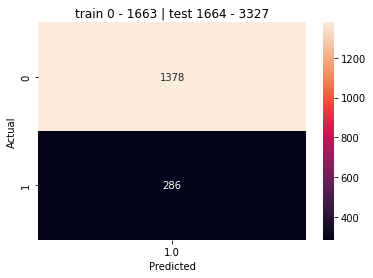

Iteration: 0
Iteration: 1


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


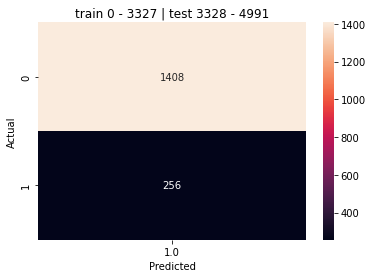

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


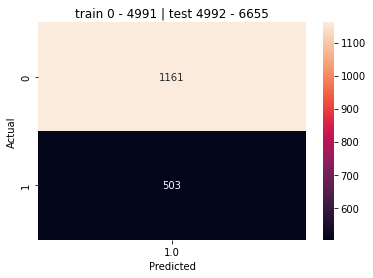

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


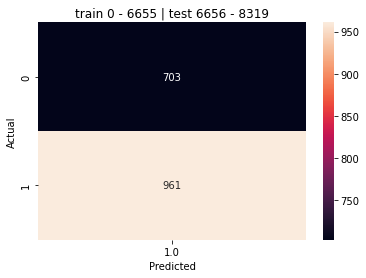

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


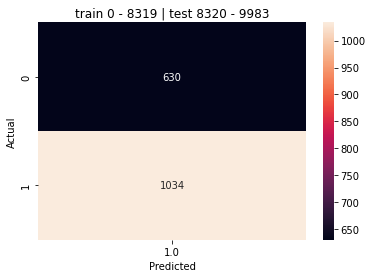

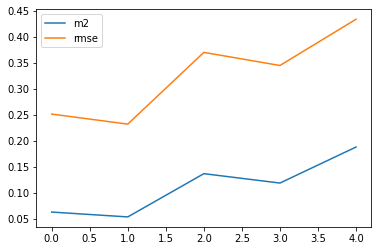

In [240]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

msquaredrf = list()
rmserf = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    # Interpolate testing data using the same imputer as for training data
    X_train_imputed = imputer.fit_transform(X_train.values)
    X_test_imputed = imputer.fit_transform(X_test.values)

    model = RandomForestRegressor(random_state=42).fit(X_train_imputed, np.ravel(y_train))
    y_pred = model.predict(X_test_imputed)
    m2 = mean_squared_error(y_val, y_pred)
    msquaredrf.append(m2)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    rmserf.append(rmse)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['crisis'], binary=True) # Plot confusion matrix

plt.plot(msquaredrf)
plt.plot(rmserf)
plt.legend(['m2', 'rmse']) 
plt.show()



Iteration: 0
Iteration: 1
Iteration: 2


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


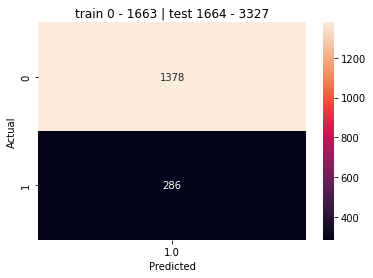

Iteration: 0
Iteration: 1
Iteration: 2


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


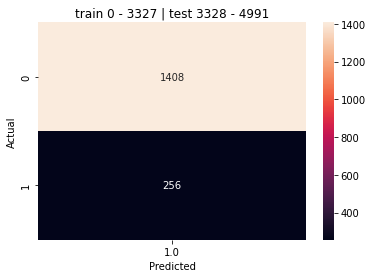

Iteration: 0
Iteration: 1
Iteration: 2


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


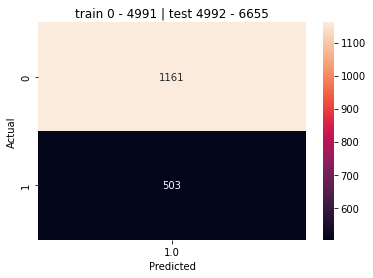

Iteration: 0
Iteration: 1
Iteration: 2


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


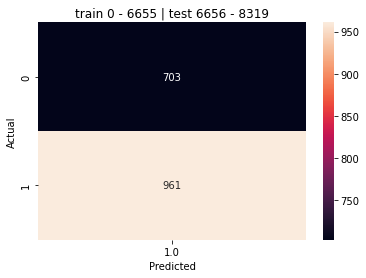

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


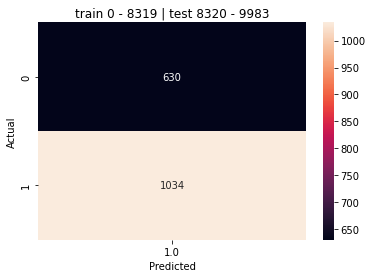

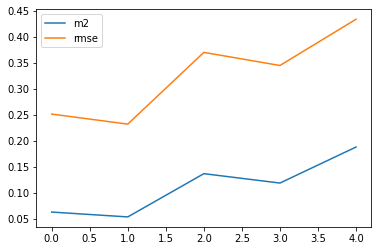

In [241]:
msquaredgb = list()
rmsegb = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    # Interpolate testing data using the same imputer as for training data
    X_train_imputed = imputer.fit_transform(X_train.values)
    X_test_imputed = imputer.fit_transform(X_test.values)

    model = GradientBoostingRegressor(random_state=42).fit(X_train_imputed, np.ravel(y_train))
    y_pred = model.predict(X_test_imputed)
    m2 = mean_squared_error(y_val, y_pred)
    msquaredgb.append(m2)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    rmsegb.append(rmse)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['crisis'], binary=True) # Plot confusion matrix

plt.plot(msquaredrf)
plt.plot(rmserf)
plt.legend(['m2', 'rmse']) 
plt.show()

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- conflict
- corruption
- humanitarian
- hunger
- livestock
- ...

  warnings.warn(message, FutureWarning)


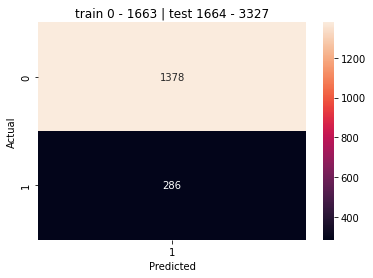

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1378
           1       0.89      0.80      0.84       286

    accuracy                           0.95      1664
   macro avg       0.92      0.89      0.91      1664
weighted avg       0.95      0.95      0.95      1664

Iteration: 0
Iteration: 1


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


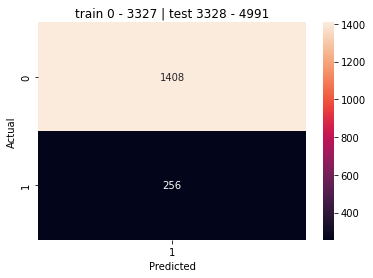

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1408
           1       0.86      0.82      0.84       256

    accuracy                           0.95      1664
   macro avg       0.91      0.90      0.90      1664
weighted avg       0.95      0.95      0.95      1664

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


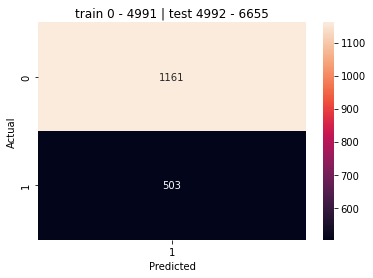

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1161
           1       0.85      0.83      0.84       503

    accuracy                           0.90      1664
   macro avg       0.89      0.88      0.88      1664
weighted avg       0.90      0.90      0.90      1664

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


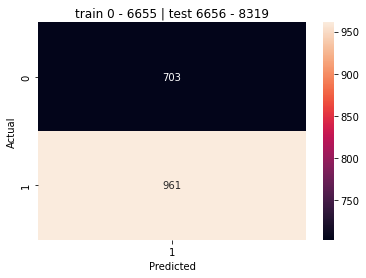

              precision    recall  f1-score   support

           0       0.82      0.90      0.85       703
           1       0.92      0.85      0.88       961

    accuracy                           0.87      1664
   macro avg       0.87      0.87      0.87      1664
weighted avg       0.87      0.87      0.87      1664

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


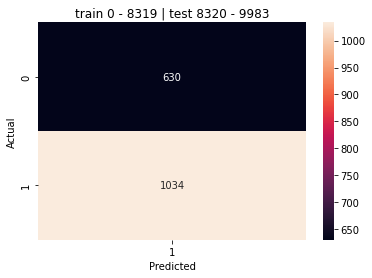

              precision    recall  f1-score   support

           0       0.76      0.77      0.76       630
           1       0.86      0.86      0.86      1034

    accuracy                           0.82      1664
   macro avg       0.81      0.81      0.81      1664
weighted avg       0.82      0.82      0.82      1664

Mean Accuracy: 0.898918
[0.9489182692307693, 0.9513221153846154, 0.9026442307692307, 0.8701923076923077, 0.8215144230769231]


<Figure size 432x288 with 0 Axes>

In [243]:
# Initinalize empty lists to score scores
accuracy_values = list()

df2 = df_copy.copy()
df2.set_index('administrative_region', append=True, inplace=True)
X_new = df2.iloc[:, -16:-1] # Define explanatory variables
X_new = sm.add_constant(X_new) # Add constant column of 1s for intercept
y_new = df2[["crisis"]] # Define target data

for train_index, val_index in cv.split(X_new): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X_new.iloc[train_index], X_new.iloc[val_index]
    y_train, y_val = y_new.iloc[train_index], y_new.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]

    #Interpolate training data to generate more training points
    X_train = X_train.groupby('administrative_region', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('administrative_region', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    # Interpolate testing data using the same imputer as for training data
    X_train_imputed = imputer.fit_transform(X_train.values)
    X_test_imputed = imputer.fit_transform(X_test.values)

    # Train the RandomForestClassifier
    # number of trees is 100, and  42 is just to initialize random number to make random choices during training
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    results = rf_classifier.fit(X=X_train_imputed, y=np.ravel(y_train))

    rf_classifier.feature_names_in_ = list(X.columns)

    # Predict on the test data
    y_pred = rf_classifier.predict(X_test)
    
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_values.append(accuracy)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['crisis'], binary=True) # Plot confusion matrix

    print (classification_report(y_val,y_pred))


print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print MAE
print(accuracy_values)